<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Visualising-some-data-from-the-LOPEX'93-dataset" data-toc-modified-id="Visualising-some-data-from-the-LOPEX'93-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualising some data from the LOPEX'93 dataset</a></span><ul class="toc-item"><li><span><a href="#Comments" data-toc-modified-id="Comments-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comments</a></span></li></ul></li><li><span><a href="#Model-inversion" data-toc-modified-id="Model-inversion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model inversion</a></span><ul class="toc-item"><li><span><a href="#Simple-PROSPECT-inversion" data-toc-modified-id="Simple-PROSPECT-inversion-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Simple PROSPECT inversion</a></span><ul class="toc-item"><li><span><a href="#Some-exercises..." data-toc-modified-id="Some-exercises...-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Some exercises...</a></span></li></ul></li></ul></li><li><span><a href="#Final-remarks" data-toc-modified-id="Final-remarks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final remarks</a></span></li></ul></div>

<div style="float:right">
    <table>
    <tr>
        <td> <img src="figs/kcl_logo.png" alt="Drawing" style="width:54px;height:40px;"/> 
        <td> <img src="figs/nceo_logo.png" alt="Drawing" style="width:200px;height:40px;"/> 
        <td> <img src="figs/multiply_logo.png" alt="Drawing" style="width:40px;height:40px;"/>
    </tr>
    </table>
</div>


# Bayesian inversion of the PROSPECT model

**Author:** Jose Gómez-Dans (NCEO & UCL)  `jose.gomez-dans@kcl.ac.uk`

## Introduction

In the previous notebook, we explored using MCMC to explore the $LAI-C_{ab}$ space. Here, we'll expand on this with PROSPECT, extending the retrieval with additional information in a Bayesian framework.

The main idea behind Bayesian statistics is, *very loosely speaking* that you combine the \emph{evidence} provided by the observations with additional \emph{a priori} information. One important step is to start thinking that all parameters aren't just a set of numbers in a vector, but rather that they follow a probability density function (pdf). So instead of talking about $N$ or $C_{ab}$ as a single number, we can think of them as pdfs. The pdf describes the region of parameter space where we believe the true parameter lies. So a peaky, thin pdf suggests that our parameter is very well localised, whereas a coarse, spread-out pdf implies that the parameter cannot be identified very well. A second important point is t

%load_ext autoreload
%autoreload 2

from prosail_functions import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize

import ipywidgets as widgets

## Visualising some data from the LOPEX'93 dataset

The [LOPEX'93 dataset](https://data.ecosis.org/dataset/13aef0ce-dd6f-4b35-91d9-28932e506c41/resource/4029b5d3-2b84-46e3-8fd8-c801d86cf6f1/download/leaf-optical-properties-experiment-93-lopex93.pdf) has been widely used. It contains carefully measured sets of leaf reflectance and transmittance for a number of samples. Each sample contains five replicates. The widget below allows you to plot these samples. Note that some of the samples may be missing. Just skip over to another one!

In [2]:
widgets.interact(read_lopex_sample,
                               sample_no=widgets.IntSlider(min=1, 
                               max=116, value=23))
refl, trans = read_lopex_sample.data

interactive(children=(IntSlider(value=23, description='sample_no', max=116, min=1), Checkbox(value=True, descr…

### Comments

Note that after running the previous widget, the reflectance and transmittance values are stored in the variables `refl` and `trans`. These will be used later!

* Can you recognise some features of these samples? Eg absorption features
* What can you say about the replicates and our ability to measure spectra?
* Are there some regions of the spectrum that appear more problematic than others?
* How can you reconcile these five replicates with uncertainty in the measurements?

## Model inversion

The problem at hand is that we want to estimate, from a set of leaf reflectance and transmittance measurements over the solar reflective domain, the PROSPECT input parameters that result in the measurements. Since our model is able to predict the observations, the obvious thing to do is to *minimise the difference* between predictions and observations. So $M_{\rho}(\mathbf{x}, \lambda)$ and $M_{\tau}(\mathbf{x}, \lambda)$ represent the predicted reflectance and transmittance (respectively) calculated by PROSPECT with an input vector $\mathbf{x}$ (where $\mathbf{x}=\left[ N, Cab, Car, Csen, Cw,Cm\right]$) at a wavelength $\lambda$. The measurements will be denoted by $\rho(\lambda)$ and $\tau(\lambda)$, for refletance and transmittance (respectively). The least squares problem is then given by the minimisation of $J(\mathbf{x})$:

$$
J(\mathbf{x}) = \sum_{\lambda=400\,nm}^{2500\,nm} \left[ M_{rho}(\mathbf{x}, \lambda) - \rho(\lambda)  \right]^{2} + \sum_{\lambda=400\,nm}^{2500\,nm} \left[ M_{tau}(\mathbf{x}, \lambda) - \tau(\lambda)  \right]^{2}.
$$


### Simple PROSPECT inversion

We will be using some leaf spectra either from the field, or from the LOPEX'93 database. We provide you with two Python functions:

* **``read_lopex_sample``** reads a particular sample from the LOPEX database. Each sample has 5 replicates.
* **``optimise_random_starts``** minimises the misfit (e.g. $J(\mathbf{x})$ above) using a set of reflectance and transmittance measurements

``optimise_random_starts`` allows you to pass reflectance and/or transmittance and will start the minimisation in ten different randomly-chosen starting points in parameter space. You can also code up your own cost function and pass it to the main function if you want to change how the cost function is calculated.

You can use the `refl` and `trans` variables from the previous GUI. The first element is the replicate (0 to 4).


Start 1 => 	Cost 0.248019 & Parameters: n:  1.43 cab: 51.47 car: 8.503 cbrown: 0.141 cw:0.008388 cm:0.007205 
Start 2 => 	Cost 0.264623 & Parameters: n: 1.429 cab: 49.31 car: 15.72 cbrown:0.1424 cw:0.008384 cm:0.007213 
Start 3 => 	Cost 0.240904 & Parameters: n:  1.43 cab:    48 car: 9.317 cbrown:0.1685 cw:0.00841 cm:0.007162 
Start 4 => 	Cost 0.240914 & Parameters: n:  1.43 cab: 48.08 car: 9.216 cbrown:0.1681 cw:0.00841 cm:0.007162 
Start 5 => 	Cost 0.32603 & Parameters: n: 1.429 cab: 60.81 car: 4.295 cbrown:0.0944 cw:0.008357 cm:0.007267 
Start 6 => 	Cost 0.243016 & Parameters: n:  1.43 cab: 48.95 car: 10.58 cbrown:0.1553 cw:0.008398 cm:0.007186 
Start 7 => 	Cost 0.244633 & Parameters: n:  1.43 cab: 47.05 car: 11.65 cbrown:0.1699 cw:0.008409 cm:0.007164 
Start 8 => 	Cost 0.243723 & Parameters: n:  1.43 cab: 47.38 car: 11.36 cbrown:0.1674 cw:0.008407 cm:0.007168 
Start 9 => 	Cost 0.240904 & Parameters: n:  1.43 cab:    48 car: 9.317 cbrown:0.1685 cw:0.00841 cm:0.007162 
Start 10 => 	C

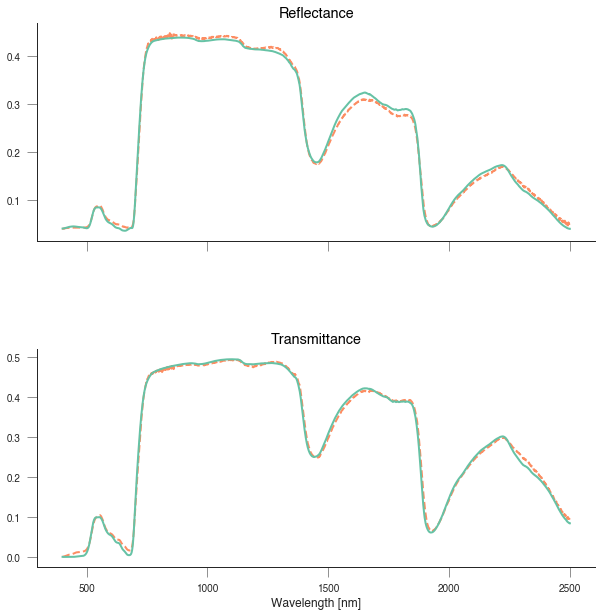

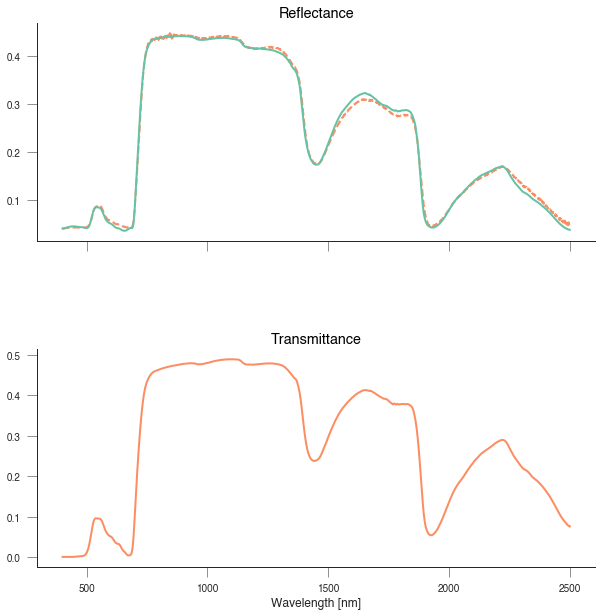

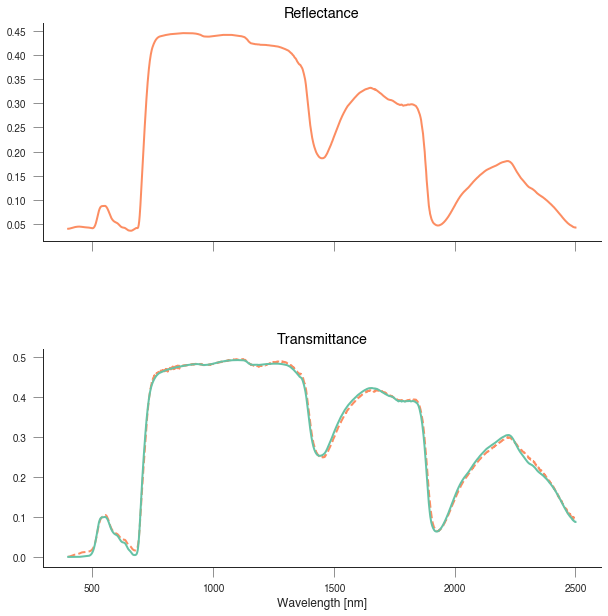

In [4]:

optimise_random_starts(refl[0, :], trans[0, :])
print("==================================================================")
optimise_random_starts(refl[0, :], None)
print("==================================================================")
optimise_random_starts(None, trans[0, :])
print("==================================================================")


#### Some exercises...

* Try the above inversions for a couple of different samples, and try several of the replicates for each sample. Compare the results, what do you see?
* You can also compare the results if using only reflectance or only transmittance.
* You can just invert each replicate independently with a simple loop. Something like this may work

```python

for i in range(5):
    print("==================================================================")
    print("===========================> Replicate %d <==========================="%(i+1))
    retval = optimise_random_starts (refl[i, :], trans[i, :], do_plots=False);
    # Switch off plotting
    # Can also set n_tries to a different value to do more or less random starting points
```
* Look at the results of the parameters over these 5 replicates and 10 random starting points. Do you notice anything interesting?
* What if you only use reflectance rather than both reflectance and transmittance?
* The five replicates are typically fairly noisy. We can take their difference as a statement of the **measurement uncertainty**. Can you suggest a way how you could modify the cost function in order to account for this? Here's how the cost function currently looks like:

```python
def cost_function ( x, refl, trans ):
    """Calculates a cost function using PROSPECT predictions and refl and trans data.
    Parameters
    ----------
    x: array
       A 6-element array, with the following order: 
       n, cab, car, cbrown, cw, cm 
    refl: array
        A 2101 element array with leaf reflectance (400-2500 nm).
        Can be `None` if not used/available.
    trans: array
        A 2101 element array with leaf tarnsmitance (400-2500 nm)
        Can be `None` if not used/available.
        
    Returns
    -------
    The sum of squared differences between model and observations
    """
    retval = call_prospect_5 ( *x )
    if refl is None:
        cost_refl = 0.
    else:
        cost_refl = ( refl - retval[ :, 0])**2
    if trans is None:
        cost_trans = 0.
    else:
        cost_trans = ( trans - retval[ :, 1])**2
    return np.sum ( cost_refl  + cost_trans )
```
* Uncertaint inputs certainly suggest uncertain outputs! Can you think of a way in which we could estimate the uncertainty in the outputs as a function of input uncertainty? 


## Final remarks

The previous example you have explored how to fit the PROSPECT model to some measurements of reflectance and transmittance from the LOPEX'93 datasets. We have seen that the starting points decision is important: in some cases, the minimisation does not converge, but in general, there are many "acceptable minima". 

We have seen that the inversion is quite unstable when changing the replicates due to measurement error. The implication here is that a number of replicates for each sample are needed to assess the measurement noise. We have also seen that using both reflectance and transmittance tends to result in better (meaning more stable) results.

There are other observations to bear in mind. One is that the parameters of the PROSPECT model vary over several orders of magnitude. This will always present a challenge to a function optimiser like the one we're using. A better way of proceeding would be to rescale all parameters to be of the same broad magnitude. We have also assumed that each spectral 1 nm bin is independent of each other. This is unlikely, so this will probably result in over-confident inversions.

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.